# About the notebook
This script computes random forest models based on the features generated as part of the thesis. Different adjustments of the models are tested (e.g. scaled data, Principal Component Analysis for dimensionality reduction, adjusting the hyperparameter, hyperparameter optimization).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import savgol_filter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import RocCurveDisplay

# Read in the data

In [2]:
# params
cancer_type = "breast_cancer"
GC = "corrected"
score = "MIDPOINT"
amplitude = "FFT"

In [3]:
# breast cancer features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_"+GC+"_"+score+"_"+amplitude+"_features.csv"
c_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_"+cancer_type+"_metadata.tsv"
c_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

c_features = c_features.reset_index(drop=False)
c_features[['sample','p','score']] = c_features['index'].str.split('_',2, expand=True)
c_features = c_features.set_index('sample')
cancer = pd.concat([c_features, c_meta], axis=1)

In [4]:
# healthy features
file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_"+GC+"_"+score+"_"+amplitude+"_features.csv"
h_features = pd.read_csv(file, sep="\t", index_col=0)

file = "/data/gpfs-1/groups/ag_kircher/cfDNA-analysis/lea/cfDNA_classification_analyses/features/DELFI_healthy_metadata.tsv"
h_meta = pd.read_csv(file, sep='\t', index_col='sample_name')

h_features = h_features.reset_index(drop=False)
h_features[['sample','p','score']] = h_features['index'].str.split('_',2, expand=True)
h_features = h_features.set_index('sample')
healthy = pd.concat([h_features, h_meta], axis=1)

In [5]:
# concat breast cancer and healthy
data = pd.concat([cancer, healthy], axis=0) #pd.concat([data1, data2], axis=0)

features = data.columns[(data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('amplitude')) | (data.columns.str.startswith('nucleosome_spacing_fft'))]
features_phenotype = data.columns[(data.columns.str.startswith('phenotype')) | (data.columns.str.startswith('central_cov')) | (data.columns.str.startswith('mean_cov')) | (data.columns.str.startswith('amplitude')) | (data.columns.str.startswith('nucleosome_spacing_fft'))]

data.head()

,index,phenotype,central_coverage_NFKB2,mean_coverage_NFKB2,amplitude190_NFKB2,nucleosome_spacing_fft_NFKB2,central_coverage_TP73,mean_coverage_TP73,amplitude190_TP73,nucleosome_spacing_fft_TP73,...,Gender,Stage,Age,Status,% GC,Length,Median,≥ 1X,≥ 5X,fraction
EGAF00002727253,EGAF00002727253_c_MIDPOINT,1.0,0.921859,0.999899,5.964870,148.0,0.993629,0.999585,15.140059,192.0,...,F,I,54.0,breast_cancer,41%,140 bp,2.0X,88.0%,1.0%,0.06429
EGAF00002727240,EGAF00002727240_c_MIDPOINT,1.0,0.966934,1.000200,19.353707,192.0,1.033113,1.000039,9.433198,240.0,...,F,II,61.0,breast_cancer,42%,143 bp,2.0X,88.0%,3.0%,0.36440
EGAF00002727280,EGAF00002727280_c_MIDPOINT,1.0,1.161236,0.999987,11.505221,213.0,1.115174,0.999805,17.278634,192.0,...,F,II,37.0,breast_cancer,42%,134 bp,2.0X,86.0%,1.0%,0.09767
EGAF00002727290,EGAF00002727290_c_MIDPOINT,1.0,1.027811,0.999776,20.178665,192.0,1.038958,1.000246,3.898227,160.0,...,F,II,48.0,breast_cancer,41%,139 bp,2.0X,89.0%,2.0%,0.06922
EGAF00002727254,EGAF00002727254_c_MIDPOINT,1.0,1.118326,1.000246,10.611337,213.0,1.166457,0.999947,1.834101,213.0,...,F,II,47.0,breast_cancer,41%,134 bp,1.0X,86.0%,1.0%,0.11470


In [6]:
# split into a training (75%) and testing set (25%)
train,test = train_test_split(data, test_size = 0.25, random_state = 42)

X_train = train[features]
y_train = train.loc[:,"phenotype"]
X_test = test[features]
y_test = test.loc[:,"phenotype"]

In [7]:
# scale data
scaled_data = pd.concat([cancer, healthy], axis=0) 
scaler = StandardScaler()
scaler.fit(scaled_data[features])
scaled_data[features] = scaler.transform(scaled_data[features])
scaled_data[features].mean()

scaled_data.head()

,index,phenotype,central_coverage_NFKB2,mean_coverage_NFKB2,amplitude190_NFKB2,nucleosome_spacing_fft_NFKB2,central_coverage_TP73,mean_coverage_TP73,amplitude190_TP73,nucleosome_spacing_fft_TP73,...,Gender,Stage,Age,Status,% GC,Length,Median,≥ 1X,≥ 5X,fraction
EGAF00002727253,EGAF00002727253_c_MIDPOINT,1.0,-1.587964,-0.402804,-1.431977,-2.181180,-1.235524,-2.211313,0.879156,-0.406840,...,F,I,54.0,breast_cancer,41%,140 bp,2.0X,88.0%,1.0%,0.06429
EGAF00002727240,EGAF00002727240_c_MIDPOINT,1.0,-0.575681,1.081786,0.380465,-0.469377,-0.233665,0.148223,-0.184884,1.386579,...,F,II,61.0,breast_cancer,42%,143 bp,2.0X,88.0%,3.0%,0.36440
EGAF00002727280,EGAF00002727280_c_MIDPOINT,1.0,3.787805,0.031149,-0.681981,0.347620,1.848499,-1.066968,1.277891,-0.406840,...,F,II,37.0,breast_cancer,42%,134 bp,2.0X,86.0%,1.0%,0.09767
EGAF00002727290,EGAF00002727290_c_MIDPOINT,1.0,0.791448,-1.014266,0.492140,-0.469377,-0.085350,1.227604,-1.216876,-1.602453,...,F,II,48.0,breast_cancer,41%,139 bp,2.0X,89.0%,2.0%,0.06922
EGAF00002727254,EGAF00002727254_c_MIDPOINT,1.0,2.824170,1.308605,-0.802986,0.347620,3.149750,-0.327229,-1.601730,0.377780,...,F,II,47.0,breast_cancer,41%,134 bp,1.0X,86.0%,1.0%,0.11470


In [8]:
# split scaled data into a training (75%) and testing set (25%)
train_scaled,test_scaled = train_test_split(scaled_data, test_size = 0.25, random_state = 42)

X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled.loc[:,"phenotype"]
X_test_scaled = test_scaled[features]
y_test_scaled = test_scaled.loc[:,"phenotype"]

# Functions

In [9]:
def get_AUC_griffin(prob,data):
    #get AUC and accuracy for each bootstrap
    probabilities = pd.DataFrame(index=data.index)
    probabilities[0] = pd.Series(prob[:,1], index = X_test.index)
    probabilities = probabilities.merge(data[['phenotype']], left_index=True, right_index=True)

    AUCs = pd.DataFrame()

    probabilities = probabilities.merge(data[['fraction','Status','Stage','Median']], left_index=True, right_index=True)
    
    for i in range(1):
        current_dict = {}
        current = probabilities[~(probabilities[i].isnull())][['phenotype','fraction','Status','Stage','Median',i]].copy()

        #overall accuracy and AUC
        group = 'overall'
        fpr,tpr,_ = roc_curve(current['phenotype'],current[i])
        AUC = auc(fpr,tpr)
        current_dict[group] = AUC
        mean_fpr = fpr
        mean_tpr = tpr
        del(AUC,group,fpr,tpr)

        #separate out the healthy samples to be used in every AUC
        healthy_df = current[current['phenotype']==0]
        cancer_df = current[current['phenotype']==1]
        del(current)
        
        for group,df in cancer_df.groupby('Status'):
            if group == 'Duodenal_Cancer':
                continue

            df2 = df.append(healthy_df, ignore_index=True)
            fpr,tpr,_ = roc_curve(df2['phenotype'],df2[i])
            AUC = auc(fpr,tpr)
            current_dict[group] = AUC
            del(AUC,group,fpr,tpr)
        
        for group,df in cancer_df.groupby('Median'):
            df2 = df.append(healthy_df, ignore_index=True)
            fpr,tpr,_ = roc_curve(df2['phenotype'],df2[i])
            AUC = auc(fpr,tpr)
            current_dict[group] = AUC
            del(AUC,group,fpr,tpr)
        
        AUCs = AUCs.append(pd.Series(current_dict), ignore_index=True)
        
    CIs = pd.DataFrame([AUCs.median(), AUCs.quantile(.025), AUCs.quantile(.975)]).T
    CIs = CIs.rename(columns = {'Unnamed 0':'median'})    
    return(AUCs,CIs,mean_fpr,mean_tpr)

In [10]:
def roc_data(prob,data):
    #get AUC and accuracy for each bootstrap
    probabilities = pd.DataFrame(index=data.index)
    probabilities[0] = pd.Series(prob[:,1], index = X_test.index)
    probabilities = probabilities.merge(data[['phenotype']], left_index=True, right_index=True)
    probabilities = probabilities.merge(data[['fraction','Status','Stage','Median']], left_index=True, right_index=True)
    
    AUCs = pd.DataFrame()
    current_dict = {}
    current = probabilities[~(probabilities[0].isnull())][['phenotype','fraction','Status','Stage','Median',0]].copy()

    #overall accuracy and AUC
    group = 'overall'
    fpr,tpr,_ = roc_curve(current['phenotype'],current[0])
    AUC = auc(fpr,tpr)
    current_dict[group] = AUC

    AUCs = AUCs.append(pd.Series(current_dict), ignore_index=True)
        
    CIs = pd.DataFrame([AUCs.median(), AUCs.quantile(.025), AUCs.quantile(.975)]).T
    CIs = CIs.rename(columns = {'Unnamed 0':'median'})    
    return(fpr,tpr,AUC)

In [11]:
def calculate_RF(data, PCA_flag, adjustment_flag, iterations):
    fraction_variance = .8
    probabilities = pd.DataFrame(index=data.index)
    c_vals = []
    coefs = pd.DataFrame(index=features)
    train_indexes = []

    # Loop for each iteration
    for i in range(iterations):

        train_internal,test_internal = train_test_split(data, test_size = 0.25, random_state = i+100) #, random_state = 42
        X_train_internal = train_internal[features]
        y_train_internal = train_internal.loc[:,"phenotype"]
        X_test_internal = test_internal[features]
        y_test_internal = test_internal.loc[:,"phenotype"]
        
        if PCA_flag == True:
            #perform PCA on the training set
            n_components = min(len(features), len(X_train_internal))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train_internal[features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train_internal.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test_internal[features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test_internal.index)

            X_train_internal = principal_components[pca_features]
            X_test_internal = test_principal_components[pca_features]
    
        if adjustment_flag == True:
            model = RandomForestClassifier(max_samples=81, min_samples_leaf=3,n_estimators=300)
        else:
            model = RandomForestClassifier()

        #train a new model 
        model.fit(X_train_internal, y_train_internal)

        #predict the test data
        pred = model.predict(X_test_internal)
        prob = model.predict_proba(X_test_internal)

        #save results
        probabilities[i] = pd.Series(prob[:,1], index = X_test_internal.index)
        acc = accuracy_score(y_test_internal, pred)
        train_indexes.append(list(X_train_internal.index))

        if i%20==0:
            #prevent dfs from becoming too fragmented
            probabilities = probabilities.copy()
            coefs = coefs.copy()

    probabilities = probabilities.merge(data[['phenotype']], left_index=True, right_index=True)
    AUCs = pd.DataFrame()
    probabilities = probabilities.merge(data[['fraction','Status','Stage']], left_index=True, right_index=True)

    for i in range(iterations):
        current_dict = {}
        current = probabilities[~(probabilities[i].isnull())][['phenotype','fraction','Status','Stage',i]].copy()

        #overall accuracy and AUC
        group = 'overall'
        fpr,tpr,_ = roc_curve(current['phenotype'],current[i])
        AUC = auc(fpr,tpr)
        current_dict[group] = AUC
        del(AUC,group,fpr,tpr)

        #separate out the healthy samples to be used in every AUC
        healthy_df = current[current['phenotype']==0]
        cancer_df = current[current['phenotype']==1]
        del(current)

        for group,df in cancer_df.groupby('Status'):
            if group == 'Duodenal_Cancer':
                continue

            df2 = df.append(healthy_df, ignore_index=True)
            fpr,tpr,_ = roc_curve(df2['phenotype'],df2[i])
            AUC = auc(fpr,tpr)
            current_dict[group] = AUC
            del(AUC,group,fpr,tpr)

        AUCs = AUCs.append(pd.Series(current_dict), ignore_index=True)

    CIs = pd.DataFrame([AUCs.median(), AUCs.quantile(.025), AUCs.quantile(.975)]).T
    CIs = CIs.rename(columns = {'Unnamed 0':'median'}) 
    return(acc,CIs)

In [44]:
def hyperparameter_optimization_RF(data, PCA_flag, HPO_type, iterations):
    fraction_variance = .8
    probabilities = pd.DataFrame(index=data.index)
    coefs = pd.DataFrame(index=features)
    train_indexes = []

    # Loop for each iteration
    for i in range(iterations):

        train_internal,test_internal = train_test_split(data, test_size = 0.25, random_state = i+100) #, random_state = 42
        X_train_internal = train_internal[features]
        y_train_internal = train_internal.loc[:,"phenotype"]
        X_test_internal = test_internal[features]
        y_test_internal = test_internal.loc[:,"phenotype"]
        
        if PCA_flag == True:
            #perform PCA on the training set
            n_components = min(len(features), len(X_train_internal))
            pca = PCA(n_components=n_components, svd_solver='randomized', random_state = 100)
            PCs = pca.fit_transform(X_train_internal[features])
            principal_components = pd.DataFrame(data = PCs, columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_train_internal.index)

            #find the principle components that make up 80% of the varience
            for j in range(len(pca.explained_variance_ratio_)):
                current_sum = pca.explained_variance_ratio_[:j].sum()
                if current_sum>=fraction_variance:
                    break
            pca_features = ['PC_'+str(m) for m in np.arange(0,j)]

            #apply to the test data
            test_PCs = pca.transform(X_test_internal[features])
            test_principal_components = pd.DataFrame(data = test_PCs , columns = ['PC_'+str(m) for m in np.arange(n_components)], index = X_test_internal.index)

            X_train_internal = principal_components[pca_features]
            X_test_internal = test_principal_components[pca_features]
        
        if HPO_type == "random" and i == 0:
            n_estimators = range(100,501,50) #list [start:stop:step], np arange
            #max_features = np.arange(50,251,50)
            min_samples_leaf = range(2,6)
            max_samples = np.arange(61,73,2)
            #max_depth = range(3,16)

            random_grid = {'n_estimators': n_estimators,
                           #'max_features': max_features,
                           'min_samples_leaf': min_samples_leaf, 
                           'max_samples': max_samples,
                           'bootstrap': [True]} 
                           #'max_depth': max_depth}

            cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = i+100) 
            rf = RandomForestClassifier()
            random_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 500, cv = cv, verbose=2, random_state=41, n_jobs = -1)
            random_search.fit(X_train_internal, y_train_internal)

            best_n_estimators = random_search.best_params_['n_estimators']
            #best_max_features = random_search.best_params_['max_features']
            best_min_samples_leaf = random_search.best_params_['min_samples_leaf']
            best_max_samples = random_search.best_params_['max_samples']
        
        if HPO_type == "grid" and i == 0:
            n_estimators = range(100,501,50) #list [start:stop:step], np arange
            #max_features = np.arange(50,251,50)
            min_samples_leaf = range(2,6)
            max_samples = np.arange(61,73,2)
            #max_depth = range(3,16)

            full_grid = {'n_estimators': n_estimators,
                       #'max_features': max_features,
                       'min_samples_leaf': min_samples_leaf, 
                       'max_samples': max_samples,
                       'bootstrap': [True]} 
                       #'max_depth': max_depth}

            cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = i+100) 
            rf = RandomForestClassifier()
            grid_search = GridSearchCV(estimator = rf, param_grid = full_grid,  cv = cv, verbose=2, n_jobs = -1)
            grid_search.fit(X_train_internal, y_train_internal)

            best_n_estimators = grid_search.best_params_['n_estimators']
            #best_max_features = grid_search.best_params_['max_features']
            best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
            best_max_samples = grid_search.best_params_['max_samples']
        
        model = RandomForestClassifier(max_samples=best_max_samples, min_samples_leaf=best_min_samples_leaf, n_estimators=best_n_estimators)
        
        #train a new model 
        model.fit(X_train_internal, y_train_internal)

        #predict the test data
        pred = model.predict(X_test_internal)
        prob = model.predict_proba(X_test_internal)

        #save results
        probabilities[i] = pd.Series(prob[:,1], index = X_test_internal.index)
        acc = accuracy_score(y_test_internal, pred)
        train_indexes.append(list(X_train_internal.index))

        if i%20==0:
            #prevent dfs from becoming too fragmented
            probabilities = probabilities.copy()
            coefs = coefs.copy()

    probabilities = probabilities.merge(data[['phenotype']], left_index=True, right_index=True)
    AUCs = pd.DataFrame()
    probabilities = probabilities.merge(data[['fraction','Status','Stage']], left_index=True, right_index=True)

    for i in range(iterations):
        current_dict = {}
        current = probabilities[~(probabilities[i].isnull())][['phenotype','fraction','Status','Stage',i]].copy()

        #overall accuracy and AUC
        group = 'overall'
        fpr,tpr,_ = roc_curve(current['phenotype'],current[i])
        AUC = auc(fpr,tpr)
        current_dict[group] = AUC
        del(AUC,group,fpr,tpr)

        #separate out the healthy samples to be used in every AUC
        healthy_df = current[current['phenotype']==0]
        cancer_df = current[current['phenotype']==1]
        del(current)

        for group,df in cancer_df.groupby('Status'):
            if group == 'Duodenal_Cancer':
                continue

            df2 = df.append(healthy_df, ignore_index=True)
            fpr,tpr,_ = roc_curve(df2['phenotype'],df2[i])
            AUC = auc(fpr,tpr)
            current_dict[group] = AUC
            del(AUC,group,fpr,tpr)

        AUCs = AUCs.append(pd.Series(current_dict), ignore_index=True)

    CIs = pd.DataFrame([AUCs.median(), AUCs.quantile(.025), AUCs.quantile(.975)]).T
    CIs = CIs.rename(columns = {'Unnamed 0':'median'}) 
    return(acc,CIs)

# Random Forest Classifier
First try

In [13]:
# train model
rf_all_default = RandomForestClassifier(random_state = 42)
rf_all_default.fit(X_train, y_train)

# test model
predict_train = rf_all_default.predict(X_train)
predict_test = rf_all_default.predict(X_test)
probability_test = rf_all_default.predict_proba(X_test)

accuracy_score(y_test, predict_test)

0.7407407407407407

In [14]:
AUCs,CIs,mean_fpr,mean_tpr = get_AUC_griffin(probability_test,data)
CIs

,median,0.025,0.975
1.0X,1.000000,1.000000,1.000000
2.0X,0.792308,0.792308,0.792308
3.0X,0.865385,0.865385,0.865385
breast_cancer,0.832418,0.832418,0.832418
overall,0.832418,0.832418,0.832418


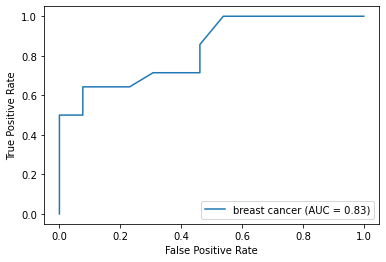

In [15]:
# display ROC curve
fpr,tpr,roc_auc = roc_data(probability_test,data)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='breast cancer')
display.plot()

# Random Forest Classifier
First train a random forest with all features on default parameters

In [16]:
# default model 
acc,CIs = calculate_RF(data, False, False, 1)
print(acc)
print(CIs)

0.7037037037037037
               median  0.025  0.975
breast_cancer     0.7    0.7    0.7
overall           0.7    0.7    0.7


In [17]:
# default model over 1,000 iterations
acc,CIs = calculate_RF(data, False, False, 1000)
print(acc)
print(CIs)

0.5925925925925926
                 median    0.025     0.975
breast_cancer  0.857143  0.69316  0.972277
overall        0.857143  0.69316  0.972277


In [18]:
# default model using Principal Component Analysis to reduce dimensionality
acc,CIs = calculate_RF(data, True, False, 1)
print(acc)
print(CIs)

0.6296296296296297
                 median     0.025     0.975
breast_cancer  0.702778  0.702778  0.702778
overall        0.702778  0.702778  0.702778


In [19]:
# default model using Principal Component Analysis to reduce dimensionality over 1,000 iterations
acc,CIs = calculate_RF(data, True, False, 1000)
print(acc)
print(CIs)

0.6666666666666666
                 median     0.025     0.975
breast_cancer  0.616572  0.401086  0.795499
overall        0.616572  0.401086  0.795499


Rerun the models using scaled data.

In [20]:
# default model with scaled data
acc,CIs = calculate_RF(scaled_data, False, False, 1)
print(acc)
print(CIs)

0.6296296296296297
                 median     0.025     0.975
breast_cancer  0.688889  0.688889  0.688889
overall        0.688889  0.688889  0.688889


In [21]:
# default model over 1,000 iterations with scaled data
acc,CIs = calculate_RF(scaled_data, False, False, 1000)
print(acc)
print(CIs)

0.6296296296296297
                 median     0.025     0.975
breast_cancer  0.858333  0.699972  0.974446
overall        0.858333  0.699972  0.974446


In [22]:
# default model using Principal Component Analysis to reduce dimensionality with scaled data
acc,CIs = calculate_RF(scaled_data, True, False, 1)
print(acc)
print(CIs)

0.5185185185185185
                 median     0.025     0.975
breast_cancer  0.583333  0.583333  0.583333
overall        0.583333  0.583333  0.583333


In [23]:
# default model using Principal Component Analysis to reduce dimensionality over 1,000 iterations with scaled data
acc,CIs = calculate_RF(scaled_data, True, False, 1000)
print(acc)
print(CIs)

0.5555555555555556
                 median     0.025     0.975
breast_cancer  0.801136  0.644066  0.933333
overall        0.801136  0.644066  0.933333


Now use a random forest model with adjusted hyperparameters.

In [24]:
# adjusted model 
acc,CIs = calculate_RF(data, False, True, 1)
print(acc)
print(CIs)

0.6666666666666666
                 median     0.025     0.975
breast_cancer  0.738889  0.738889  0.738889
overall        0.738889  0.738889  0.738889


In [25]:
# adjusted model over 1,000 iterations
acc,CIs = calculate_RF(data, False, True, 1000)
print(acc)
print(CIs)

0.7037037037037037
                 median     0.025     0.975
breast_cancer  0.873626  0.722161  0.977778
overall        0.873626  0.722161  0.977778


In [26]:
# adjusted model using Principal Component Analysis to reduce dimensionality
acc,CIs = calculate_RF(data, True, True, 1)
print(acc)
print(CIs)

0.6296296296296297
                 median     0.025     0.975
breast_cancer  0.622222  0.622222  0.622222
overall        0.622222  0.622222  0.622222


In [27]:
# adjusted model using Principal Component Analysis to reduce dimensionality over 1,000 iterations
acc,CIs = calculate_RF(data, True, True, 1000)
print(acc)
print(CIs)

0.5925925925925926
                 median     0.025     0.975
breast_cancer  0.618483  0.407129  0.811111
overall        0.618483  0.407129  0.811111


And use the adjusted model with scaled data.

In [28]:
# adjusted model with scaled data
acc,CIs = calculate_RF(scaled_data, False, True, 1)
print(acc)
print(CIs)

0.7777777777777778
                 median     0.025     0.975
breast_cancer  0.794444  0.794444  0.794444
overall        0.794444  0.794444  0.794444


In [29]:
# adjusted model over 1,000 iterations with scaled data
acc,CIs = calculate_RF(scaled_data, False, True, 1000)
print(acc)
print(CIs)

0.7037037037037037
               median     0.025     0.975
breast_cancer   0.875  0.714206  0.977778
overall         0.875  0.714206  0.977778


In [30]:
# adjusted model using Principal Component Analysis to reduce dimensionality with scaled data
acc,CIs = calculate_RF(scaled_data, True, True, 1)
print(acc)
print(CIs)

0.6296296296296297
               median  0.025  0.975
breast_cancer    0.65   0.65   0.65
overall          0.65   0.65   0.65


In [31]:
# adjusted model using Principal Component Analysis to reduce dimensionality over 1,000 iterations with scaled data
acc,CIs = calculate_RF(scaled_data, True, True, 1000)
print(acc)
print(CIs)

0.6296296296296297
                 median     0.025     0.975
breast_cancer  0.807692  0.649959  0.938889
overall        0.807692  0.649959  0.938889


When comparing all these model, it shows that using scaled data does not improve the model. This was expected of a tree-based model. However, the scaled data was still used as it did not reduce model performance and is still needed for PCA, which is a linear approach to reduce dimensionality. It also makes all three models more comparable. 
PCA did not improve but rather reduce model performance. This means that still a model with way many features than samples is used and other ways need to be found to reduce dimensionality. PCA reduces dimensionality unaware of the sample's class abels and is therefore considered an unsupervised approach. This makes PCA a sub-optimal approach for the classification problem of this thesis.

# Hyperparameter optimization
Try different hyperparameter optimization techniques to find the optimal values for hyperparameters.

In [33]:
### RF with all features using randomized search CV

n_estimators = range(100,501,50) #list [start:stop:step], np arange
max_features = np.arange(50,251,50)
min_samples_leaf = range(2,6)
max_samples = np.arange(61,73,2)
max_depth = range(3,16)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf, 
               'max_samples': max_samples,
               'max_depth': max_depth}


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 41) 
rf = RandomForestClassifier()
rf_all_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 500, cv = cv, verbose=2, random_state=41, n_jobs = -1)
rf_all_random.fit(X_train, y_train)
              
predict_train = rf_all_random.predict(X_train)
predict_test = rf_all_random.predict(X_test)
probability_test = rf_all_random.predict_proba(X_test)

accuracy_score(y_test, predict_test)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


0.7407407407407407

In [34]:
# best_score_
print('best score', rf_all_random.best_score_)

# best_estimator_
print('best estimator', rf_all_random.best_estimator_)

# best_params_
print('best params', rf_all_random.best_params_)

best score 0.8388888888888889
best estimator RandomForestClassifier(max_depth=4, max_features=100, max_samples=61,
                       min_samples_leaf=3, n_estimators=200)
best params {'n_estimators': 200, 'min_samples_leaf': 3, 'max_samples': 61, 'max_features': 100, 'max_depth': 4}


In [35]:
### RF with all features on the parameters of random grid hyperparameter optimization

# best params
best_n_estimators = rf_all_random.best_params_['n_estimators']
best_max_features = rf_all_random.best_params_['max_features']
best_min_samples_leaf = rf_all_random.best_params_['min_samples_leaf']
best_max_samples = rf_all_random.best_params_['max_samples']

# train model
rf_all_random_adj = RandomForestClassifier(max_features=best_max_features, max_samples=best_max_samples, min_samples_leaf=best_min_samples_leaf, n_estimators=best_n_estimators, random_state=41)
rf_all_random_adj.fit(X_train, y_train)

# test model

predict_train = rf_all_random_adj.predict(X_train)
predict_test = rf_all_random_adj.predict(X_test)
probability_test = rf_all_random_adj.predict_proba(X_test)

accuracy_score(y_test, predict_test)

0.7037037037037037

In [36]:
### RF with all features using grid search CV

n_estimators = range(100,501,50) #list [start:stop:step], np arange
max_features = np.arange(50,251,50)
min_samples_leaf = range(2,6)
max_samples = np.arange(61,65,2)
#max_depth = range(3,16)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf, 
               'max_samples': max_samples,
               'bootstrap': [True]} 
               #'max_depth': max_depth}

rf = RandomForestClassifier()
rf_all_grid = GridSearchCV(estimator = rf, param_grid = random_grid,  cv = 5, verbose=2, n_jobs = -1)
rf_all_grid.fit(X_train, y_train)
              
predict_train = rf_all_grid.predict(X_train)
predict_test = rf_all_grid.predict(X_test)
probability_test = rf_all_grid.predict_proba(X_test)

accuracy_score(y_test, predict_test)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


0.7037037037037037

In [37]:
# best_score_
print('best score', rf_all_grid.best_score_)

# best_estimator_
print('best estimator', rf_all_grid.best_estimator_)

# best_params_
print('best params', rf_all_grid.best_params_)

best score 0.8507352941176471
best estimator RandomForestClassifier(max_features=50, max_samples=61, min_samples_leaf=2)
best params {'bootstrap': True, 'max_features': 50, 'max_samples': 61, 'min_samples_leaf': 2, 'n_estimators': 100}


In [38]:
### RF with all features on the parameters of random grid hyperparameter optimization

# best params
best_n_estimators = rf_all_grid.best_params_['n_estimators']
best_max_features = rf_all_grid.best_params_['max_features']
best_min_samples_leaf = rf_all_grid.best_params_['min_samples_leaf']
best_max_samples = rf_all_grid.best_params_['max_samples']

# train model
rf_all_grid_adj = RandomForestClassifier(max_features=best_max_features, max_samples=best_max_samples, min_samples_leaf=best_min_samples_leaf, n_estimators=best_n_estimators, random_state=41)
rf_all_grid_adj.fit(X_train, y_train)

# test model

predict_train = rf_all_grid_adj.predict(X_train)
predict_test = rf_all_grid_adj.predict(X_test)
probability_test = rf_all_grid_adj.predict_proba(X_test)

accuracy_score(y_test, predict_test)

0.7037037037037037

Calculate model performance using random and grid search with different number of iterations using PCA to reduce the dimensionality or not.

In [41]:
# Random search without PCA
acc,CIs = hyperparameter_optimization_RF(data, False, "random", 1)
print(acc)
print(CIs)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
0.7777777777777778
                 median     0.025     0.975
breast_cancer  0.755556  0.755556  0.755556
overall        0.755556  0.755556  0.755556


In [42]:
# Random search without PCA over 1000 iterations
acc,CIs = hyperparameter_optimization_RF(data, False, "random", 1000)
print(acc)
print(CIs)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
0.7407407407407407
                 median     0.025     0.975
breast_cancer  0.862637  0.698864  0.966676
overall        0.862637  0.698864  0.966676


In [45]:
# Random search with PCA over 1000 iterations
acc,CIs = hyperparameter_optimization_RF(data, True, "random", 1000)
print(acc)
print(CIs)

/fast/users/lburkar_m/work/miniconda/envs/jupyter/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 216 is smaller than n_iter=500. Running 216 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 216 candidates, totalling 2160 fits
0.5925925925925926
                 median     0.025     0.975
breast_cancer  0.605719  0.394444  0.802205
overall        0.605719  0.394444  0.802205


In [46]:
# Grid search without PCA
acc,CIs = hyperparameter_optimization_RF(data, False, "grid", 1)
print(acc)
print(CIs)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
0.7037037037037037
                 median     0.025     0.975
breast_cancer  0.722222  0.722222  0.722222
overall        0.722222  0.722222  0.722222


In [47]:
# Grid search without PCA over 1000 iterations
acc,CIs = hyperparameter_optimization_RF(data, False, "grid", 1000)
print(acc)
print(CIs)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
0.7037037037037037
                 median     0.025     0.975
breast_cancer  0.869318  0.703694  0.977784
overall        0.869318  0.703694  0.977784


In [48]:
# Grid search with PCA over 1000 iterations
acc,CIs = hyperparameter_optimization_RF(data, True, "grid", 1000)
print(acc)
print(CIs)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
0.5185185185185185
                 median     0.025     0.975
breast_cancer  0.607955  0.401099  0.807692
overall        0.607955  0.401099  0.807692


Hyperparameter optimization is highly variable between different runs and gives worse results compared to the default model, which should not happen. If the default parameter give a better perfromance these should be used in HPO. (HPO optimizes for accuracy and therefore this should at least be the same.) This indicates that the optimization does not work. In a dataset tht suffers from the curse of dimensionality determining the optimal value for each parameter is challenging. In this scenario it might be better to set the parameter manually according to the requirement of the data.